In [2]:
%%bash
pip install -U scikit-learn

  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
ERROR: kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.6.1 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement numpy<1.16,>=1.13, but you'll have numpy 1.18.1 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 0.22.1 which is incompatible.
ERROR: hypertools 0.6.2 has requirement scikit-learn<0.22,>=0.19.1, but you'll have scikit-learn 0.22.1 which is incompatible.
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompatible.


In [3]:
# !pip install imblearn
!pip install missingpy

     |████████████████████████████████| 51kB 2.5MB/s eta 0:00:011


1) Importing packages and Loading Data

In [4]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
from missingpy import KNNImputer
import scipy.stats as ss
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split as tts,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix,roc_auc_score,precision_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.svm import SVC

In [6]:
train_data = pd.read_csv("../input/train.csv")
train_data.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,3433,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,7,MALAYSIA,0.0,17.82,NaN,31
1,4339,EPX,Travel Agency,Online,Cancellation Plan,0,85,SINGAPORE,69.0,0.00,NaN,36
2,34590,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,11,MALAYSIA,19.8,11.88,NaN,75
3,55816,EPX,Travel Agency,Online,2 way Comprehensive Plan,0,16,INDONESIA,20.0,0.00,NaN,32
4,13816,EPX,Travel Agency,Online,Cancellation Plan,0,10,"KOREA, REPUBLIC OF",15.0,0.00,NaN,29


In [7]:
test_data = pd.read_csv("../input/test.csv")
test_data.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,25902,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,58,ICELAND,49.5,29.7,NaN,47
1,19535,EPX,Travel Agency,Online,2 way Comprehensive Plan,4,SINGAPORE,20.0,0.0,NaN,24
2,43717,EPX,Travel Agency,Online,2 way Comprehensive Plan,68,VIET NAM,20.0,0.0,NaN,36
3,48271,EPX,Travel Agency,Online,2 way Comprehensive Plan,41,CHINA,28.0,0.0,NaN,36
4,52318,EPX,Travel Agency,Online,Cancellation Plan,16,SINGAPORE,11.0,0.0,NaN,36


In [8]:
target = train_data['Claim']

In [9]:
train_id = train_data['ID']
test_id = test_data['ID']

In [10]:
train_data.drop('ID',1,inplace=True)
test_data.drop('ID',1,inplace=True)

2) Checking for missing values and handling missing values

In [11]:
train_data.isnull().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Claim                       0
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Gender                  35953
Age                         0
dtype: int64

In [12]:
## Gender has more than 70% missing values
train_data.drop(['Gender'],1,inplace=True)
test_data.drop(['Gender'],1,inplace=True)

3) Exploratory Data Analysis
>>i) checking distribution of target variable

Text(0.5, 0, 'Number of Claim')

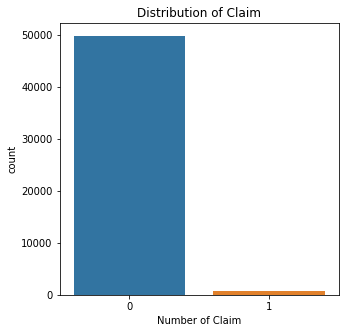

In [13]:
#plot count plot of Claim variable - clear Class imbalance
plt.figure(figsize=(5,5))
ax = sns.countplot(x="Claim", data=train_data)
plt.title('Distribution of Claim')
plt.xlabel('Number of Claim')

ii) EDA for numerical variable
>>a) Univariate Analysis

>>b) Bivariate Analysis

In [14]:
numerical_features = train_data.select_dtypes(include=np.number)
numerical_features.head()

,Claim,Duration,Net Sales,Commision (in value),Age
0,0,7,0.0,17.82,31
1,0,85,69.0,0.00,36
2,0,11,19.8,11.88,75
3,0,16,20.0,0.00,32
4,0,10,15.0,0.00,29


In [15]:
numerical_cols = numerical_features.columns
list(numerical_cols)

['Claim', 'Duration', 'Net Sales', 'Commision (in value)', 'Age']

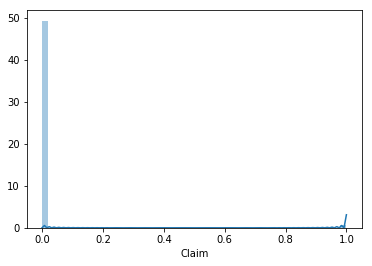

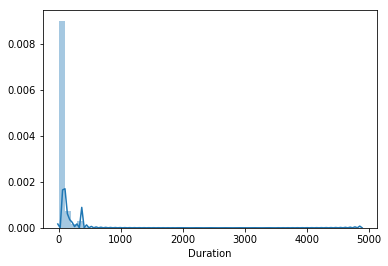

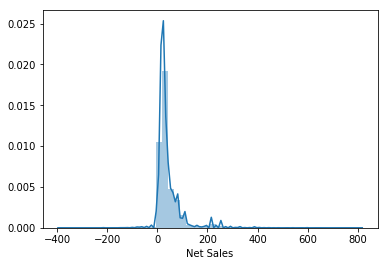

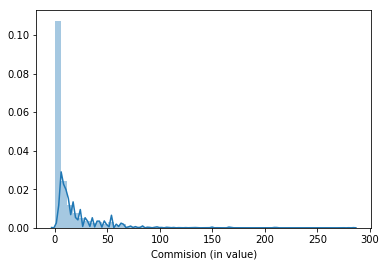

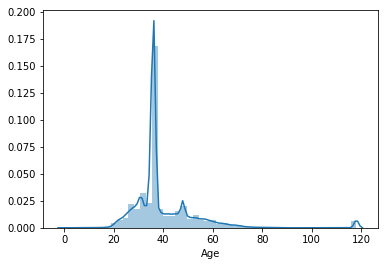

In [16]:
##Checking distribution of the numerical columns
for i in numerical_cols:
    sns.distplot(numerical_features[i])
    plt.show()

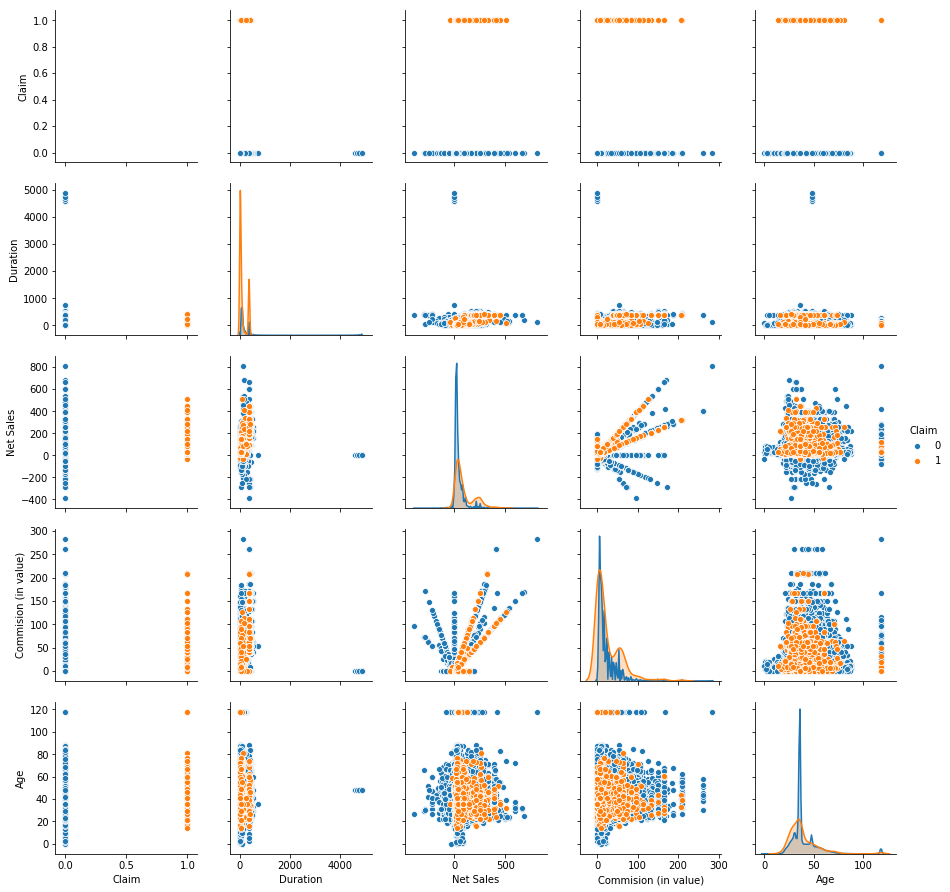

In [17]:
## checking variation of numerical col with other numerical cols
sns.pairplot(numerical_features, hue="Claim")

Observations from pair plot wrt claim column <br>
1) for All values of duration above ~ 800 all claims are rejected<br>
2) for net sales value less than ~ 0 all claims are rejected<br>
3) for age less than ~ 10 all claims are rejected<br>

In [18]:
corr = numerical_features.corr()
corr

,Claim,Duration,Net Sales,Commision (in value),Age
Claim,1.000000,0.076442,0.138323,0.102009,-0.012106
Duration,0.076442,1.000000,0.437004,0.349193,0.003212
Net Sales,0.138323,0.437004,1.000000,0.657851,0.039119
Commision (in value),0.102009,0.349193,0.657851,1.000000,0.119167
Age,-0.012106,0.003212,0.039119,0.119167,1.000000


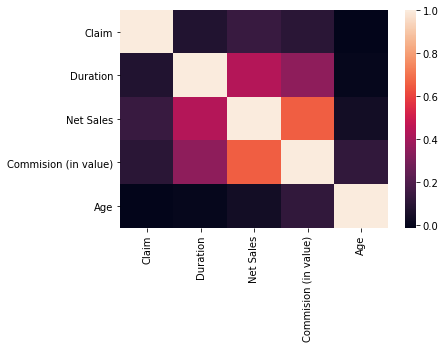

In [19]:
sns.heatmap(corr)

iii) EDA for categorical variable

>>a) Univariate Analysis

>>b) Bivariate Analysis

>>c) Correlation between categorical variables


In [20]:
categorical_features = train_data.select_dtypes(exclude=np.number)
categorical_features.head()

,Agency,Agency Type,Distribution Channel,Product Name,Destination
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,MALAYSIA
1,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,MALAYSIA
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,INDONESIA
4,EPX,Travel Agency,Online,Cancellation Plan,"KOREA, REPUBLIC OF"


In [21]:
categorical_cols = categorical_features.columns
list(categorical_cols)

['Agency',
 'Agency Type',
 'Distribution Channel',
 'Product Name',
 'Destination']

In [22]:
categorical_features['Claim'] = target

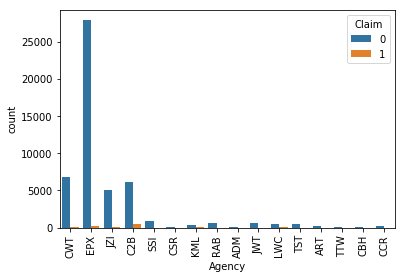

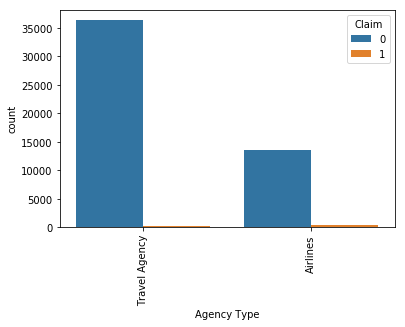

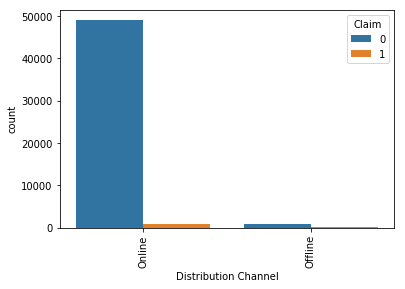

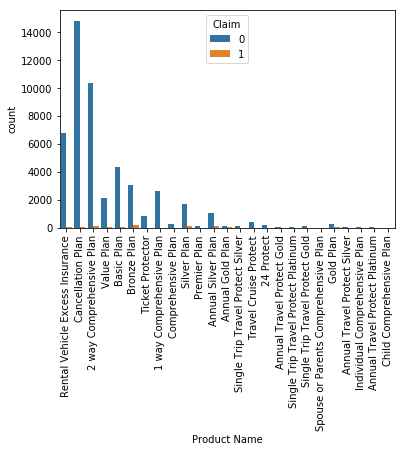

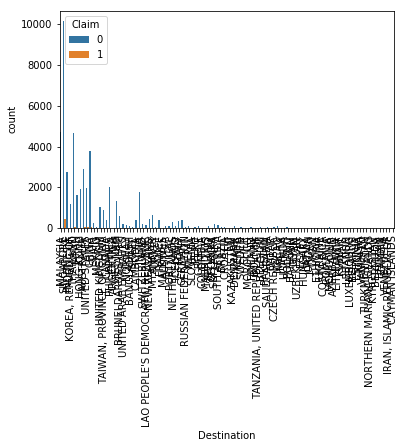

In [23]:
## Countplot for all categrocial features
for i in categorical_cols:
    sns.countplot(data = categorical_features , x = i, hue='Claim')
    plt.xticks(rotation = 90)
    plt.show()

In [24]:
## Correlation between categorical features using chi-square

#Function to calculate importance of features using Chi-Square test
def Chi_square(col_1,col_2):
    X=categorical_features[col_1].astype('str')
    Y=categorical_features[col_2].astype('str')
    observed_values=pd.crosstab(Y,X)
    chi2, p, dof, expected = ss.chi2_contingency(observed_values)
    if(p>0.05):
        print(col_1," is not required")
    else:
        print(col_1," is required")

In [25]:
for col in list(categorical_cols):
    Chi_square(col,"Claim")

Agency  is required
Agency Type  is required
Distribution Channel  is not required
Product Name  is required
Destination  is required


4) Data preprocessing as per EDA

>> i) Fpr Numerical variables

>> ii) For categorical variables

In [26]:
## For numerical variables

# all claims above ~800 rejected
train_data.loc[train_data["Duration"] >= 740, ['Duration']] = 740
test_data.loc[train_data["Duration"] >= 740, ['Duration']] = 740

In [27]:
# duration is time period thats why it can not be negative
train_data.loc[train_data["Duration"] <= 0, ['Duration']] = 0
test_data.loc[test_data["Duration"] <= 0, ['Duration']] = 0

In [28]:
# for all the values below ~-20 all the claims are rejected
train_data.loc[train_data["Net Sales"] <= -20, ['Net Sales']] = -20
test_data.loc[test_data["Net Sales"] <= -20, ['Net Sales']] = -20

# for all the values above ~550 all the claims are rejected
train_data.loc[train_data["Net Sales"] >= 550, ['Net Sales']] = 550
test_data.loc[test_data["Net Sales"] >= 550, ['Net Sales']] = 550

In [29]:
# for all Commision above ~220 all the claims are rejeted
train_data.loc[train_data["Commision (in value)"] >= 220, ['Commision (in value)']] = 220
test_data.loc[test_data["Commision (in value)"] >= 220, ['Commision (in value)']] = 220

In [30]:
# age below less than ~15 all claims are rejected
train_data.loc[train_data["Age"] <= 15, ['Age']] = 15
test_data.loc[test_data["Age"] <= 15, ['Age']] = 15

# age below less than ~15 all claims are rejected
train_data.loc[train_data["Age"] >= 85, ['Age']] = 85
test_data.loc[test_data["Age"] >= 85, ['Age']] = 85

In [31]:
## For categorical variable. As per correlation, Distribution channel is dropped and agency type to avoid multicollinearity
train_data.drop(['Distribution Channel','Agency Type'],1,inplace=True)
test_data.drop(['Distribution Channel','Agency Type'],1,inplace=True)

5) Encoding data

In [32]:
train_data = pd.get_dummies(train_data, drop_first=True)
test_data = pd.get_dummies(test_data, drop_first=True)

In [33]:
train_data.head()

,Claim,Duration,Net Sales,Commision (in value),Age,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,Agency_CSR,...,Destination_UGANDA,Destination_UKRAINE,Destination_UNITED ARAB EMIRATES,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_UZBEKISTAN,Destination_VANUATU,Destination_VENEZUELA,Destination_VIET NAM,Destination_ZAMBIA
0,0,7,0.0,17.82,31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,85,69.0,0.00,36,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,11,19.8,11.88,75,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,16,20.0,0.00,32,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,10,15.0,0.00,29,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
test_data.head()

,Duration,Net Sales,Commision (in value),Age,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,Agency_CSR,Agency_CWT,...,Destination_UGANDA,Destination_UKRAINE,Destination_UNITED ARAB EMIRATES,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_UZBEKISTAN,Destination_VANUATU,Destination_VENEZUELA,Destination_VIET NAM,Destination_ZAMBIA
0,58,49.5,29.7,47,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,4,20.0,0.0,24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,68,20.0,0.0,36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,41,28.0,0.0,36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,16,11.0,0.0,36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


6) Scaling data

In [35]:
train_data.drop(['Claim'],1,inplace=True)

In [36]:
sc = MinMaxScaler()
train_data_scaled = pd.DataFrame(sc.fit_transform(train_data), columns=train_data.columns)
train_data_scaled.head()

,Duration,Net Sales,Commision (in value),Age,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,Agency_CSR,Agency_CWT,...,Destination_UGANDA,Destination_UKRAINE,Destination_UNITED ARAB EMIRATES,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_UZBEKISTAN,Destination_VANUATU,Destination_VENEZUELA,Destination_VIET NAM,Destination_ZAMBIA
0,0.009459,0.035088,0.081,0.228571,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.114865,0.156140,0.000,0.300000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.014865,0.069825,0.054,0.857143,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.021622,0.070175,0.000,0.242857,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.013514,0.061404,0.000,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
test_data_scaled = pd.DataFrame(sc.transform(test_data), columns=test_data.columns)
test_data_scaled.head()

,Duration,Net Sales,Commision (in value),Age,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,Agency_CSR,Agency_CWT,...,Destination_UGANDA,Destination_UKRAINE,Destination_UNITED ARAB EMIRATES,Destination_UNITED KINGDOM,Destination_UNITED STATES,Destination_UZBEKISTAN,Destination_VANUATU,Destination_VENEZUELA,Destination_VIET NAM,Destination_ZAMBIA
0,0.078378,0.121930,0.135,0.457143,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.005405,0.070175,0.000,0.128571,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.091892,0.070175,0.000,0.300000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.055405,0.084211,0.000,0.300000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.021622,0.054386,0.000,0.300000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> 7) Applying models with SMOTE

Model:  Logistic Regression

Training score:  0.7764491844416561
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      9962
           1       0.05      0.70      0.09       149

    accuracy                           0.79     10111
   macro avg       0.52      0.75      0.48     10111
weighted avg       0.98      0.79      0.87     10111

ROC_AUC_SCORE is 0.7459948475347259
Test score:  0.7860745722480467



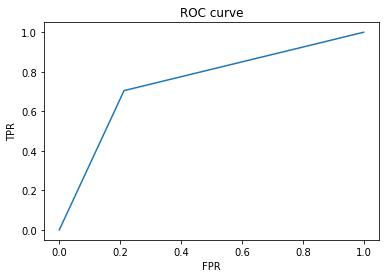


Model:  Decision Tree

Training score:  0.9660100376411543
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      9962
           1       0.04      0.09      0.05       149

    accuracy                           0.95     10111
   macro avg       0.51      0.53      0.52     10111
weighted avg       0.97      0.95      0.96     10111

ROC_AUC_SCORE is 0.5294633028326433
Test score:  0.9521313421026605



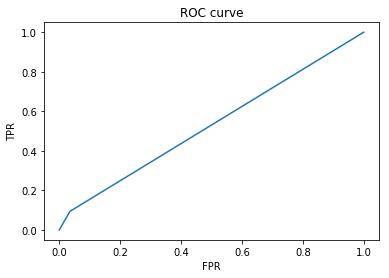


Model:  Random Forest

Training score:  0.9750188205771645
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      9962
           1       0.06      0.11      0.08       149

    accuracy                           0.96     10111
   macro avg       0.52      0.54      0.53     10111
weighted avg       0.97      0.96      0.97     10111

ROC_AUC_SCORE is 0.542642241861355
Test score:  0.9585599841756502



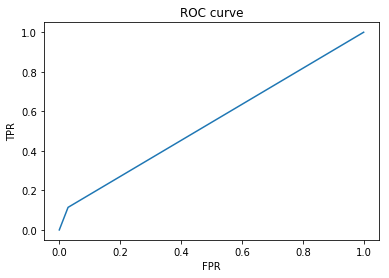


Model:  XGBoost

Training score:  0.8466875784190716
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.91      9962
           1       0.05      0.58      0.09       149

    accuracy                           0.83     10111
   macro avg       0.52      0.71      0.50     10111
weighted avg       0.98      0.83      0.89     10111

ROC_AUC_SCORE is 0.7080274169360348
Test score:  0.8285036099297794



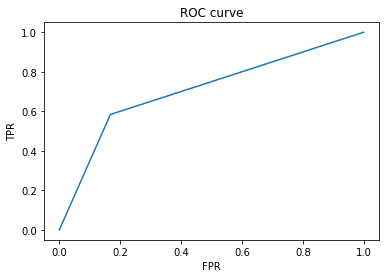


Model:  SVC



In [ ]:
def run_model(predictors,target, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = tts(predictors,target,test_size=0.2,random_state=42)
    
    sm = SMOTE(random_state=42)
    x_sm, y_sm = sm.fit_resample(x_train, y_train)
    model.fit(x_sm, y_sm)
    training_results = cross_val_score(model, x_sm,y_sm, cv = 10, scoring = 'accuracy')
    print("Training score: ",training_results.mean())
    y_scores = model.predict(x_val)
    auc = roc_auc_score(y_val, y_scores)
    print('Classification Report:')
    print(classification_report(y_val,y_scores))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_scores)
    print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_scores))
    print("Test score: ", accuracy_score(y_val,y_scores))
    #fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    print()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    



models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,'Random Forest': RandomForestClassifier,'XGBoost':XGBClassifier, 'SVC':SVC}

for i in models.items():
    # run model
    model = i[1]()
    print("Model: ", i[0])
    print()
    run_model(train_data_scaled, target, model) # train and returns AUC test score
    print('===='*20)
    print()